## Readings

Introduction to Convolutions: https://www.youtube.com/watch?v=8rrHTtUzyZA 

Nice Wiki article : https://en.wikipedia.org/wiki/Kernel_(image_processing)

Residual Networks: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

The goal of this project is to familiarize ourselves with the fundamentals of deep learning engineering for computer vision and image recognition. We will reimplement from scratch a member of the ResNet family of vision models and apply our model to classify images into different categories.

We will start by loading an existing ResNet implementation (pretrained on ImageNet), and seeing what sorts of classificaton the model can output. Then, we will discuss and implement the basic blocks of computer vision architectures. After that, we will move to ResNet, and implement the architecture using our basic blocks. We will then use our model for classifying images.

Bonus: only if you finish the other exercices!

If you can't recreate the sub modules, it's not a big deal, you can use the pytorch implementation to create your resnet in the "Assembling your resnet" part, which is the most important part.

# Prelude: image classifications from a pretrained ResNet

First, we load a pretrained ResNet model from the PyTorch vision repository.

In [ ]:
from torchvision import models
torchvision_resnet34 = models.resnet34(pretrained=True)
resnet34 = torchvision_resnet34
_ = resnet34.eval()

We will download images from the internet to feed into the model.

In [ ]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

def load_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

url = "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg"
img = load_image(url)
img

The model expects a batch of images of shape `(num_images, num_channels=3, height, width)`, and outputs the [classfication logits](https://developers.google.com/machine-learning/glossary/#logits), which is of shape `(num_images, num_classes=1000)`.

In [ ]:
import torch
from torchvision import transforms

inputs = transforms.ToTensor()(img).unsqueeze_(0)
print(inputs.shape)
outputs = resnet34(inputs)
outputs = outputs
print(outputs.shape)

We load the ImageNet class [labels](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt).

In [ ]:
imagenet_labels_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
response = requests.get(imagenet_labels_url)
imagenet_labels = eval(response.text)

We select a few random images from the internet, and check the classification results from the model, by looking at the most likely and least likely predicted classes.

In [ ]:
urls = [
    "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg",
    "https://anipassion.com/ow_userfiles/plugins/animal/breed_image_56efffab3e169.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f2/Platypus.jpg",
    "https://static5.depositphotos.com/1017950/406/i/600/depositphotos_4061551-stock-photo-hourglass.jpg",
    "https://img.nealis.fr/ptv/img/p/g/1465/1464424.jpg",
    "http://www.tudobembresil.com/wp-content/uploads/2015/11/nouvelancopacabana.jpg",
    "https://ychef.files.bbci.co.uk/976x549/p0639ffn.jpg",
    "https://www.thoughtco.com/thmb/Dk3bE4x1qKqrF6LBf2qzZM__LXE=/1333x1000/smart/filters:no_upscale()/iguana2-b554e81fc1834989a715b69d1eb18695.jpg",
    "https://i.redd.it/mbc00vg3kdr61.jpg",
    "https://static.wikia.nocookie.net/disneyfanon/images/a/af/Goofy_pulling_his_ears.jpg",
]

def show_classes_probabilities(urls, model, k=3):
    for url in urls:
        img = load_image(url)
        model.eval()

        inputs = transforms.ToTensor()(img).unsqueeze_(0)
        outputs = model(inputs)
        probs = torch.softmax(outputs, -1).flatten()
        sorted_probs, sorted_idxs = probs.sort(descending=True)
        sorted_probs = [p.item() for p in sorted_probs]
        sorted_classes = [imagenet_labels[idx.item()] for idx in sorted_idxs]

        small_img = img.copy()
        small_img.thumbnail((150, 150))
        display(small_img)
        print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
        )

show_classes_probabilities(urls, torchvision_resnet34)

# Implementing ResNet building blocks

We now start implementing our own ResNet model.

## Operating on tensors: as_strided and einsum

To implement some of our building blocks, we will use the following functions:
* `torch.einsum`: implements summations over tensor indices using Einstein notation. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.einsum.html
    * https://ajcr.net/Basic-guide-to-einsum/
* `torch.as_strided`: PyTorch tensors data are physically stored as 1-d arrays, and the shape and stride abstractions describe a multidimensional indexing API into this data. The shape (or size) is an N-tuple describing the number of valid indices for each dimension. The stride is an N-tuple corersponding to how many cells to jump in the 1-d physical array when the index of each dimension is incremented. The function `.as_strided` can then be used to change the shape and stride of a tensor without changing the underlying data. This can be used to efficiently implement many operations on tensors. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.as_strided.html
    * https://jott.live/markdown/as_strided
    
We will start this section by familiarizing ourselves with these functions by reimplementing some matrix operations.

### Step: as_strided arguments

For each test case below, change the arguments `size` and `stride`, so that a call of `torch.as_strided(test_input_a, size=size, stride=stride)` matches the desired output.

In [ ]:
from collections import namedtuple

test_input_a = torch.tensor([[ 0,  1,  2,  3,  4],
                             [ 5,  6,  7,  8,  9],
                             [10, 11, 12, 13, 14],
                             [15, 16, 17, 18, 19]])

TestCase = namedtuple('TestCase', ['output', 'size', 'stride'])

test_cases = [
  TestCase(
    output=torch.tensor([0, 1, 2, 3]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 1, 2],
                         [5, 6, 7]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 0, 0],
                         [11, 11, 11]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([0, 6, 12, 18]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[[0, 1, 2],
                          [9, 10, 11]]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[[[0, 1],
                           [2, 3]],
                          [[4, 5],
                           [6, 7]]],
                         [[[12, 13],
                           [14, 15]],
                          [[16, 17],
                           [18, 19]]]]),
    size=(1,),
    stride=(1,),
  ),
]

In [ ]:
def is_equal_test(*, output, expected, test_name='Test'):
    successful = torch.allclose(expected.to(float), output.to(float))
    if successful:
        print(f'{test_name} passed!')
    else:
        print(f'{test_name} failed')
        print(f'Output:\n{output}')
        print(f'Expected:\n{expected}')

for i, (expected, size, stride) in enumerate(test_cases):
    output = torch.as_strided(test_input_a, size=size, stride=stride)
    is_equal_test(test_name=i, output=output, expected=expected)

### Step: as_strided trace

Implement a function that receives a square matrix (as a 2d tensor) and returns its [trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra)) using `torch.as_strided` and `torch.sum`.



In [ ]:
def strided_trace(a):
    ...

In [ ]:
def einsum_trace(a):
    return torch.einsum('ii->', a)

a = torch.randn(10, 10)
assert torch.allclose(strided_trace(a), einsum_trace(a), rtol=1e-4, atol=1e-4)

### Step: as_strided matmul

Implement a function that receives two matrices (as 2d tensors) and returns their [multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication), using `torch.as_strided`, `torch.sum`, and elementwise multiplication. Do not use python's for loop;

In [ ]:
def strided_matmul(a, b):
    a0, a1 = a.shape
    b0, b1 = b.shape

    # Tip: a_strided and b_strided should have the same sizes
    # Tip2: The matrix multiplication operation is a cubic operation (O(n**3))
    a_strided = ...
    b_strided = ...

    # Now that a_strided and b_strided have the same shapes, we can multiply element by element
    mul = torch.mul(a_strided, b_strided)

    reduced_dimension = ...
    return torch.sum(mul, dim=reduced_dimension)

In [ ]:
def einsum_matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

a = torch.randn(10, 5)
b = torch.randn(5, 15)
assert torch.allclose(strided_matmul(a, b), einsum_matmul(a, b), rtol=1e-4, atol=1e-4)

Question: Explain each character in the 

## Convolutions and pooling

Convolutions are one of the fundamental operations of signal processing. It can be interpreted as a sliding window (a "kernel") that goes over all positions of the input and outputs a weighted sum of the values of the region (i.e. the dot product of the kernel and the region). Watch this 30-second video: https://www.youtube.com/watch?v=ulKbLD6BRJA

We're going to begin by implementing 1d convolutions without "padding" (when the kernel sticks off one side of the input). This means, unlike in the video, the output of the convolution will be a little smaller than the input. See the below image for examples:

<img src=../../.images/1d_conv.jpeg width=800>

We will also implement 2d convolution, in which the kernel slides around on the input in 2d, producing one weighted sum in the output for each location it occupies:

<img src=../../.images/2d_conv.png width=800>

A 1-d Convolution can be written as:

$$\operatorname{conv1d}(input, weights)[b, c_o, i] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k-1} weights[c_o, c_i, di] \cdot input[b, c_i, i+di]$$

A 2-d Convolution can be written as:
$$\operatorname{conv2d}(input, weights)[b, c_o, i, j] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k_h-1}\sum_{dj = 0}^{k_w-1} weights[c_o, c_i, di, dj] \cdot input[b, c_i, i+di, j+dj]$$


Clarification on notation: the brackets on the LHS are indices into the output of the function, which (as you can see from the number of indices) is a rank-4 tensor: batch size, num of channels, width, height.

One way to think about convolutions is that convolutions are the linear translation invariant functions. That is, if F is a function, and the following holds:
* $F(x + y) = F(x) + F(y)$
* $F(T(x)) = T(F(x))$ (where $T$ corresponds to shifting the input)

Then $F$ can be written as a convolution.

In addition to operating on a single sequence or 2d array, we'll operate on multiple input and output channels - input channels are things like the 3 colors of an image, or multiple stock tickers. Multiple output channels are independent convolutions, each of which has a weight for each input location / channel combination.

![img](../../.images/convchannels.jpeg)

### Step: conv1d arguments

To get familiarity with `conv1d`, replace the indicated variables to pass the tests below.

In [ ]:
# We will only implement conv1d
# conv2d is a bonus, we will use the torch implementation.
from torch.nn.functional import conv1d as torch_conv1d
from torch.nn.functional import conv2d as torch_conv2d

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3, 4]]])
weights = torch.tensor([[[0, 0]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([7.0, 11.0, 15.0])
is_equal_test(output=output, expected=expected)

(Bonus) Replace `input` to pass the test.

In [ ]:
input = torch.tensor([[[1, 1, 1, 1, 1, 1, 1, 1]]])
weights = torch.tensor([[[2, 0, -2]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([[[210, 30, -12, -4, -4, -4]]])
is_equal_test(output=output, expected=expected)

Replace `weights` to pass the test.

In [ ]:
# Tip: Think about the meaning of each dimension here
input = torch.tensor([[[1, 2, 3],
                       [4, 5, 6]],
                      [[1, 1, 1],
                       [2, 3, 2]]])
weights = torch.tensor([[[0], [0]]]) 
output = torch_conv1d(input, weights)
expected = torch.tensor([[[9, 12, 15]],
                         [[5, 7, 5]]])
is_equal_test(output=output, expected=expected)

### Step: conv1d

Implement 1d convolutions using `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, seqlen), weights : (out_channels, in_channels, kernel_width)

def conv1d_minimal(x, weights):
    shape = x.shape
    stride = x.stride()

    # Same trick as used for matmul: the 
    size = ...
    stride = ...
    x_strided = torch.as_strided(x, size=size, stride=stride)

    # Tip: here no need to use as_strided on weights
    # We can directly use torch.einsum
    # einsum is a generalization of matrix multiplication.
    # Tip: use meaningful letters for einsum notation
    return torch.einsum(..., x_strided, weights)
    

In [ ]:
def test_conv1d_minimal(my_conv, n_tests=10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        kernel_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, kernel_size))

        my_output = my_conv(x, weights)

        torch_output = torch.conv1d(
            x,
            weights,
            stride=1,
            padding=0,
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d (minimal) test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d_minimal(conv1d_minimal)

### Step: conv2d

(Bonus) Implement 2d convolutions (with minimal arguments). Use `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, height, width), weights : (out_channels, in_channels, kernel_height, kernel_width)

def conv2d_minimal(x, weights):
    pass

In [ ]:
def test_conv2d_minimal(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *kernel_size))

        my_output = my_conv(
            x,
            weights
        )

        torch_output = torch.conv2d(
            x,
            weights
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d_minimal(conv2d_minimal)

### Step: stride and padding

Convolutions generally take a few extra arguments, such as:
* `stride`: how many positions to increment in the input for each position increment in the output. Useful for downsampling the input.
* `padding`: pads the input with $p$ zeroes on each side before applying the convolution. Useful for controlling the output size.

(Bonus) Add `stride` and `padding` parameters to your implementations of `conv1d`, `conv2d`.

In [ ]:
# x : (batchsize, in_channels, seq_len), 
# weights : (out_channels, in_channels, kernel_width), 
# stride: int
# padding: int
def conv1d(x, weights, stride=1, padding=0):
    # Tip: Use from torch.nn.functional import pad
    ...



In [ ]:
#@title conv2d fuzz tests { form-width:"200px" }

def test_conv1d(my_conv, n_tests = 10):
    import numpy as np

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        stride = np.random.randint(1, 5)
        padding = np.random.randint(0, 5)
        kernel_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, kernel_size))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv1d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d(conv1d)

(Bonus) : Do the Same for conv2d

In [ ]:
# x : (batchsize, in_channels, height, width), 
# weights : (out_channels, in_channels, kernel_height, kernel_width), 
# stride: int or tuple(int, int)
# padding: int or tuple(int, int)
def conv2d(x, weights, stride=1, padding=0):
    pass

In [ ]:
def test_conv2d(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)

        stride = tuple(np.random.randint(1, 5, size=(2,)))
        padding = tuple(np.random.randint(0, 5, size=(2,)))
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *kernel_size))
        bias = torch.randn((co,))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv2d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d(conv2d)



### Step: maxpool2d

Poolings have the same format as convolutions - only that instead of outputting a weighted sum, max poolings output the maximum value of the window, and average poolings output the average.

Implement 2d max pooling using `torch.as_strided` and `torch.amax`.


In [ ]:
# x : (batchsize, in_channels, height, width), 
# kernel_size : int or tuple(int, int)
# stride: None or int or tuple(int, int) (assume stride=kernel_size if None)
# padding: int or tuple(int, int)

def maxpool2d(x, kernel_size, stride=None, padding=0):
    pass

In [ ]:
#@title maxpool2d fuzz tests { form-width: "200px" }

from torch.nn.functional import max_pool2d as torch_maxpool2d

# Fuzz test
def test_maxpool(my_maxpool2d, n_tests = 100):
    import numpy as np
    
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)

        none_stride = bool(np.random.randint(2))
        if none_stride:
            stride = None
        else:
            stride = tuple(np.random.randint(1, 5, size=(2,)))
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))
        kH, kW = kernel_size
        padding = np.random.randint(0, 1 + kH//2), np.random.randint(0, 1 + kW//2)

        x = torch.randn((b, ci, h, w))

        my_output = my_maxpool2d(
            x,
            kernel_size,
            stride=stride,
            padding=padding,
        )

        torch_output = torch_maxpool2d(
            x,
            kernel_size,
            stride=stride,
            padding=padding,
        )
        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print('A test failed!')
            print('input:')
            print(x)
            print('----------')
            print('output:')
            print(my_output)
            print('expected:')
            print('----------')
            print(torch_output)
            return

    print('All tests passed!')

test_maxpool(maxpool2d)


### Step: Conv2d, MaxPool2d Modules

Implement now Conv2d and MaxPool2d classes, each inheriting `nn.Module`. When you inherit `nn.Module`, your class should define:

- `__init__()`: the constructor. At the start of your constructor, remember to call the constructor of `nn.Module` with `super().__init__()`.
- `forward()`: when your module as invoked as if it were a function with the expression `module(x)`, this results in a call to `module.forward(x)`.  

If you need more info, read our doc on `nn.Module` subclasses [here](https://docs.google.com/document/d/1PYW_lW_-jXpN394S8LtPqivSB91HjAwQi6_iDtmpwXg/edit?usp=sharing)

Crucially, your conv kernel should be wrapped in a `torch.nn.Parameter()`. When a `torch.nn.Parameter()` is assigned as an attribute of a `nn.Module`, it will get automatically registered as a learnable parameter, meaning that `model.parameters()` will include it. Additionally, by default `Parameters` keep track of their gradients, while `Tensors` by default do not.

For initializing the values of the Conv2d parameters, read [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

Do Kaiming initialization, as described in the above. The fan-in should be the number of incoming connections that a specific neuron in the conv layer has: `in_channels * kernel_width * kernel_height`

In [ ]:
from torch.nn import Module, Parameter

# Not Bonus:
# use torch.nn.conv2d for the core operation function.
# But you still have to define and initialize the kernel parameters in the __init__
class Conv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
    ):
        pass

    def forward(self, x):

        pass
        

class MaxPool2d(Module):
    def __init__(
        self,
        kernel_size,
        stride=None,
        padding=1,
    ):
        pass

    def forward(self, x):
        pass


## Batch Normalization

One intuition for batch norm is that we don't want the "units"/scale of our input features to matter, because this might distort how they get optimized relative to each other. Thus we would like to make each input feature have mean 0 and variance 1 across the population. To approximate this, we normalize each feature within its batch. We also keep a running mean/variance estimation during training that we use during testing (for more accuracy than the batch stats).

In practice, we normalize entire channels at once, rather than single pixels. This means normalizing each pixel by the mean/variance of all the pixels within that channel, across height, width, and batch.

Read more about batch normalization [here](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739), and look at the diagrams of batchnorm during training/inference for more specifics, which you'll need for your implementation.

Documentation for batchnorm: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

### Step: BatchNorm2d

Implement a BatchNorm2d module.

Tips:
- Reimplement the formula in the torch documentation
- Warning: Momentum in pytorch doc is the inverse of the usual momentum
- Some parameters should not be considered in the autograd graph, use self.register_buffer

In [ ]:
class BatchNorm2d(Module):
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.1,
    ):
        pass

    def forward(self, x):
        pass

# Assembling your ResNet

The ResNet has many features typical of vision architectures: blocks of conv + batchnorm + relu, a decreasing width/height paired with an increasing number of channels, and a linear layer at the end that produces logits. It set itself apart from other models at the time by incorporating residual blocks, which add the input to the output of the conv/batchnorm before the relu. These improved loss for large models, as it's easier to propagate signals over many layers of identity mapping + noise, than to propagate signals over many layers of noise.


[ResNet paper](https://arxiv.org/abs/1512.03385)


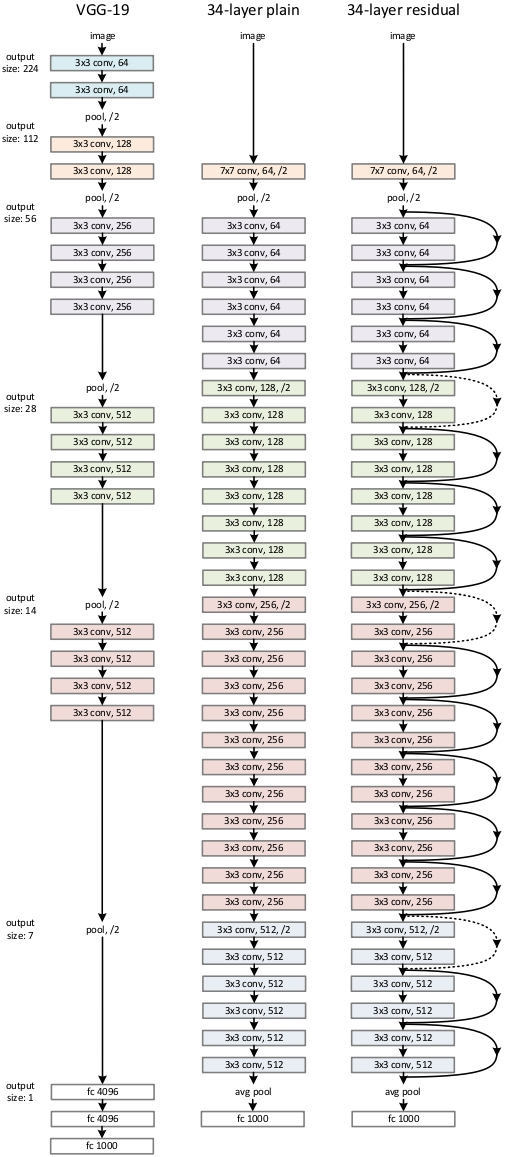

The ResNet architecture can be seen on the right of the figure above. Here is how to interpret it:
* every convolution is followed by a batch norm (and almost always by a a relu);
* "/2" means the height and width are halved (they are kept the same otherwise)
  * the padding is always $p = \frac{k-1}{2}$ (this is known as ["same" padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t), because it keeps the same size when the stride is 1)
  * the stride is 2 when there is a "/2", and 1 otherwise
* "$k \times k$ conv, $N$" represents a block of conv+batchnorm+relu, where $k \times k$ is the conv kernel size and $N$ is the number of output channels
* side arrows mean that the input is added before the relu at the output
  * bold arrows: output size equals input size, and input is added as is
  * dotted arrows: output height/width is half of the input, and double in features; in this case we downsample the input, passing it through a conv of kernel size 1x1 and stride 2;
* the "avg pool" here means a layer with input $(B, C, H, W)$ and output $(B, C, 1)$, where values over height and width dimensions are averaged out into a single value
* the "fc 1000" means a Linear layer with C input features and 1000 output features. Rather than hard-code 1000, we're going to have the number of output classes be a parameter of the model. You'll see that we've made an an argument to the ResNet class's `\_\_init\_\_` method.

Notice that, unlike an MLP, the dimensions of the input image are never hardcoded into this model.

Let's implement it step by step!

### Step: Residual block

Start by implementing a residual block (i.e. 2x conv+batchnorm+relu, and a residual connection; the number of input and output channels can vary; whether the output size is the same or is halved can also vary).

* every convolution is followed by a batch norm (and almost always by a a relu);
* "/2" means the height and width are halved (they are kept the same otherwise)
  * the padding is always $p = \frac{k-1}{2}$ (this is known as ["same" padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t), because it keeps the same size when the stride is 1)
  * the stride is 2 when there is a "/2", and 1 otherwise
* "$k \times k$ conv, $N$" represents a block of conv+batchnorm+relu, where $k \times k$ is the conv kernel size and $N$ is the number of output channels

In [17]:
import torch.nn as nn
from torch.nn import Module

# Every convolution is followed by a batch norm
class ConvNorm(Module):
  def __init__(self,in_feats, out_feats, kernel_size, downsample=False):
    '''Convolution followed by BatchNorm'''
    super().__init__()
    
    # the stride is 2 when there is a "/2", and 1 otherwise
    stride = 2 if downsample else 1

    # Always same padding
    padding = ...

    self.conv = nn.Conv2d(in_feats,out_feats, kernel_size,
                          padding=padding, stride=stride)
    self.batch_norm = nn.BatchNorm2d(out_feats)

  def forward(self,x):
    ...
    return x

* side arrows mean that the input is added before the relu at the output
  * bold arrows: output size equals input size, and input is added as is
  * dotted arrows: output height/width is half of the input, and double in features; in this case we downsample the input, passing it through a conv of kernel size 1x1 and stride 2;

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_feats, out_feats, downsample=False):
        super().__init__()
        ...

    def forward(self, x):
        ...

### Step: ResNet34

Implement now the ResNet34 architecture, according to the diagram, using the residual blocks from above.

* the "avg pool" here means a layer with input $(B, C, H, W)$ and output $(B, C, 1)$, where values over height and width dimensions are averaged out into a single value
* the "fc 1000" means a Linear layer with C input features and 1000 output features. Rather than hard-code 1000, we're going to have the number of output classes be a parameter of the model. You'll see that we've made an an argument to the ResNet class's `\_\_init\_\_` method.

In [19]:
# You can import Linear, Relu, etc from torch.nn
# You can use torch.mean

class ResNet34(nn.Module):
    def __init__(self, output_size=1000):
        super().__init__()
        ...
  
    def forward(self, x):
        ...
        return x


We write a function that copies over the weights from the torchvision pretrained resnet34 into yours. T

In [20]:
def copy_weights(my_model, torch_model):
    new_state_dict = {
        k1: v2 for (k1, _), (_, v2) in zip(my_model.state_dict().items(), torch_model.state_dict().items())}
    my_model.load_state_dict(new_state_dict)

Question: Explain what happens in the function copy_weights:
-  `model.state_dict()` and `model.load_state_dict()` ?
-  zip?
-  .items() ?

Run the following cell to confirm that your model agrees with the torchvision model at the start.

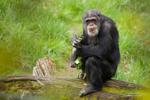

05.10% | chimpanzee, chimp, Pan troglodytes
01.48% | siamang, Hylobates syndactylus, Symphalangus syndactylus
01.32% | langur
...
00.00350% | pomegranate
00.00344% | rotisserie
00.00322% | admiral



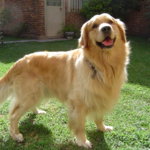

26.91% | golden retriever
05.63% | Great Pyrenees
04.29% | collie
...
00.00061% | gyromitra
00.00059% | stinkhorn, carrion fungus
00.00054% | bolete



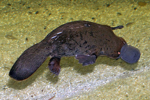

23.95% | platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
18.00% | stingray
07.01% | electric ray, crampfish, numbfish, torpedo
...
00.00044% | maypole
00.00044% | crane
00.00035% | hand-held computer, hand-held microcomputer



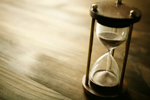

97.58% | hourglass
00.09% | beaker
00.08% | guillotine
...
00.00004% | great grey owl, great gray owl, Strix nebulosa
00.00003% | flatworm, platyhelminth
00.00003% | pickup, pickup truck



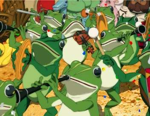

23.07% | comic book
17.85% | tray
13.01% | book jacket, dust cover, dust jacket, dust wrapper
...
00.00009% | puffer, pufferfish, blowfish, globefish
00.00007% | sports car, sport car
00.00004% | French loaf



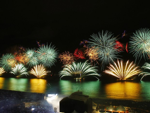

07.94% | seashore, coast, seacoast, sea-coast
07.28% | lakeside, lakeshore
04.36% | sandbar, sand bar
...
00.00210% | fig
00.00181% | cheeseburger
00.00138% | disk brake, disc brake



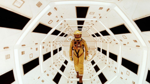

03.66% | maze, labyrinth
02.21% | vault
01.64% | dome
...
00.00203% | koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
00.00191% | jacamar
00.00137% | jellyfish



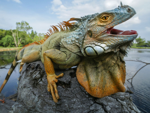

01.08% | common iguana, iguana, Iguana iguana
00.98% | bassinet
00.86% | mosquito net
...
00.00972% | police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
00.00787% | gyromitra
00.00608% | slot, one-armed bandit



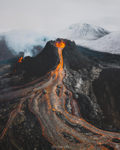

11.00% | volcano
02.99% | valley, vale
02.99% | sandbar, sand bar
...
00.00184% | bolete
00.00184% | tiger beetle
00.00102% | koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus



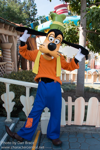

10.24% | picket fence, paling
07.19% | umbrella
02.42% | military uniform
...
00.00026% | red-breasted merganser, Mergus serrator
00.00022% | leafhopper
00.00021% | mud turtle



In [21]:
copy_weights(resnet34, torchvision_resnet34)
show_classes_probabilities(urls, resnet34)

### Training

### Step: Training your ResNet
That was too easy. Rather than importing someone else's magic parameters, let's actually train our ResNet. We're going to do so for a simpler image-recognition task, the CIFAR10 dataset. This is a dataset of 3x32x32 images that fall into 10 classes, so define a new model that just has 10 outputs. You can mostly follow along with this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. Make sure your model is in training mode by calling model.train(). 

In [ ]:
import torchvision

cifar_train = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_train",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=True)

# What is the benefit of using a Dataloader?
trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=100,
                                          shuffle=True)

model = ResNet34(n_outs=10).to(device).train()
optimizer = optim.Adam(model.parameters())

# Why do we use the CrossEntropyLoss?
# What is the difference with CrossEntropyLossWithLogits?
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 4
for _ in range(epochs):
    for i, (x, y) in enumerate(tqdm(trainloader)):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        if i % 500 == 0:
            print(f"Batch {i}, loss is {loss}")

### Displaying what your ResNet has learned:

Run the cell below to print some CIFAR images and see how your model labelled them.

In [ ]:
cifar_test = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_test",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=False)

def eval_cifar(model, num_imgs=10):
    for_display = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((128, 128))])

    cifar_classes = { 0: "airplane",
                      1: "automobile",
                      2: "bird",
                      3: "cat",
                      4: "deer",
                      5: "dog",
                      6: "frog",
                      7: "horse",
                      8: "ship",
                      9: "truck"
                    }
    model.eval()
    with torch.no_grad():
        for i in range(num_imgs):
            x, y = cifar_test[i]
            outputs = model(x.unsqueeze(0))
            probs = torch.softmax(outputs, -1).flatten()
            sorted_probs, sorted_idxs = probs.sort(descending=True)
            sorted_probs = [p.item() for p in sorted_probs]
            sorted_classes = [cifar_classes[idx.item()] for idx in sorted_idxs]

            small_img = for_display(x.cpu())
            display(small_img)
            print(f"Actual class: {cifar_classes[y]}")
            k = 2
            print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
            )

eval_cifar(my_trained_model)